In [ ]:
import cv2

In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 210.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 380.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 238.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 246.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 247.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 374.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 241.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 400.1 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.16.3
    Unin

In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=f4d2d428627de63644ecb16e6f62077e61c0b111eab716632aabef7cfa3b3b79
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ul87el1/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ff2cd77fc4a9a6bef86c3c09103c979

In [ ]:
import cv2
import os
import numpy as np
from tqdm.auto import tqdm
import re
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import segmentation_models_pytorch as smp
from albumentations import Compose, RandomResizedCrop, HorizontalFlip, Rotate
from tabulate import tabulate


In [ ]:
def divide_into_patches(image_path, patch_size, stride,output_folder,image_number):
    # Load the image
    image = cv2.imread(image_path)
    if image is not None:
        # Get image dimensions
        height, width, _ = image.shape
        count=1

        os.makedirs(output_folder, exist_ok=True)
        # Extract patches with the specified size and stride
        for y in range(0, height - patch_size[0] + 1, stride):
            for x in range(0, width - patch_size[1] + 1, stride):
                patch = image[y:y+patch_size[0], x:x+patch_size[1]]

                # Check if the patch size matches the specified size
                if patch.shape[0] == patch_size[0] and patch.shape[1] == patch_size[1]:
                    #patches.append(patch)
                    patch_filename = f'image{image_number}_patch_{count}.png'
                    patch_filepath = os.path.join(output_folder, patch_filename)
                    cv2.imwrite(patch_filepath, patch)
                    count+=1
        return True
    else:
        print(f"Failed to load the image while doing {output_folder}patches")
        return False

#input_and_sort_folder

def input_sort(folder):
    name=os.listdir(folder)
    name.sort()
    return name

#extract number from string

def extract_number_from_string(input_string):
    # Define a regular expression pattern to match all consecutive digits
    pattern = r'\d'

    # Use re.findall() to find all matches in the string
    matches = re.findall(pattern, input_string)

    # If matches are found, return the list of all matches
    if matches:
        result= [match for match in matches]
        return "".join((result))
    else:
        return None  # or raise an exception, depending on your requirements

#make_patches (calling divide_into_patches function)

def make_patches(folder):
    output_folder=f"path1_{folder}_patches"
    file=input_sort(folder)
    file=file
    for i in tqdm(file):
        #image paths must exist
        original_image_path=f"{folder}/{i}"
        image_number=extract_number_from_string(i)
        patch_size = (256, 256)
        stride = 130
        #stride=int(input("enter stride::"))
        divide_into_patches(original_image_path, patch_size, stride,output_folder,image_number)
    return output_folder

#augmentation

def augmentation(original_patches,ground_patches):

    transform = Compose([
                        RandomResizedCrop(256, 256),
                        HorizontalFlip(),
                        Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0)
                        ])

    orig_aug="path1_original_augmentation_images"
    ground_aug="path1_groundtruth_augmenation_images"

    os.makedirs(orig_aug, exist_ok=True)
    os.makedirs(ground_aug, exist_ok=True)

    count = 1

    # List all images in the source folder
    original= input_sort(original_patches)
    ground=input_sort(ground_patches)
    n=len(original)
    for im in tqdm(range(n)):

        orig_name,extension=os.path.splitext(original[im])
        gt_name,extension=os.path.splitext(ground[im])

        original_image_path=os.path.join(original_patches,original[im])
        ground_truth_path=os.path.join(ground_patches,ground[im])
        original_image = cv2.imread(original_image_path)
        ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)


        save_path_original=os.path.join(orig_aug,f"{orig_name}_{0}.jpg")
        cv2.imwrite(save_path_original,original_image)
        save_path_ground_truth = os.path.join(ground_aug, f"{gt_name}_{0}.jpg")
        cv2.imwrite(save_path_ground_truth ,ground_truth)

        for i in range(3):
            augmented_data = transform(image=original_image, mask=ground_truth)
            augmented_original = augmented_data["image"]
            augmented_ground_truth = augmented_data["mask"]

            # Save the augmented images
            save_path_original=os.path.join(orig_aug,f"{orig_name}_aug{i+1}.jpg")
            cv2.imwrite(save_path_original,augmented_original)
            save_path_ground_truth = os.path.join(ground_aug, f"{gt_name}_aug{i+1}.jpg")
            cv2.imwrite(save_path_ground_truth ,augmented_ground_truth)
    return orig_aug,ground_aug

#making dataloaders

def dataloaders(orig_train,ground_train):
    # Convert the lists to PyTorch tensors
    original_images_tensor = torch.stack([torch.Tensor(img) for img in orig_train])
    ground_images_tensor = torch.stack([torch.Tensor(img) for img in ground_train])

    # Combine the tensors into a single TensorDataset
    dataset = TensorDataset(original_images_tensor, ground_images_tensor)

    # Create a DataLoader
    batch_size = 8
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    orig_train_dataloader=[]
    ground_train_dataloader=[]
    # Iterate over the data loader to get batches of corresponding original and ground images
    for original_batch, ground_batch in tqdm(data_loader):
        # Your training/validation loop here
        orig_train_dataloader.append(original_batch)
        ground_train_dataloader.append(ground_batch)

    return orig_train_dataloader,ground_train_dataloader



#train_test_split

def train_test_split(orig,ground):
    n=len(orig)
    val=int((0.9)*n)

    orig_train=orig[:val]
    orig_test=orig[val:]

    ground_train=ground[:val]
    ground_test=ground[val:]

    return orig_train,ground_train,orig_test,ground_test

#data generation main function

def data_generation(original,groundtruth):
    #preparing patches for original
    original_patches=""
    #original_patches=make_patches(original)
    #print(f"original patches created in '{original_patches}' folder")


    #preparing patches for groundtruth
    gt_patches=""
    #gt_patches=make_patches(groundtruth)
    #print(f"ground truth patches created in '{gt_patches}' folder")

    #original_aug,ground_aug=augmentation(original_patches,gt_patches)
    original_aug="path1_original_augmentation_images"
    ground_aug="path1_groundtruth_augmenation_images"
    #print(f"original augmentation images created in '{original_aug}' folder")
    #print(f"groundtruth augmenation images created in '{ground_aug}' folder")





    # read images  from  data
    folder=original_aug
    file=input_sort(folder)
    orig=[]
    for image in tqdm(file):
        img=cv2.imread(os.path.join(folder,image))
        orig.append(torch.Tensor(img).permute(2,0,1).detach().numpy())

    folder=ground_aug
    file=input_sort(folder)
    ground=[]
    for image in tqdm(file):
        img=cv2.imread(os.path.join(folder,image),cv2.IMREAD_GRAYSCALE)
        img=img/255
        ground.append(torch.Tensor(img).unsqueeze(0).detach().numpy())

    print(f"\noriginal data shape:{orig[0].shape}\nground_data_shape{ground[0].shape}")
    print("data read from patches successfully")




    # splitting  training data ,testing data
    orig_train,ground_train,orig_test,ground_test=train_test_split(orig,ground)
    print("data splitted into training data ,testing data successfully")

    #preparing dataloaders
    orig_train_dataloader,ground_train_dataloader=dataloaders(orig_train,ground_train)
    print(f"sizes:\norig_train::{len(orig_train)}\norig_test{len(orig_test)}\nground_train::{len(ground_train)}\nground_test::{len(ground_test)}\norig_train_dataloader::{len(orig_train_dataloader)}\nground_train_dataloader{len(ground_train_dataloader)}")
    return orig_test,ground_test,orig_train_dataloader,ground_train_dataloader



# training model

#training function

def train_model(model, loss_fn, optimizer, orig_train_dataloader, ground_train_dataloader, epochs=62,save_interval=20):
    print(f"*******************training { type(model).__name__} model**********************")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.train()

    loss_values = []  # List to store loss values for each epoch

    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch + 1}/{epochs}")

        total_loss = 0

        for orig_batch, ground_batch in zip(orig_train_dataloader, ground_train_dataloader):
            orig_batch = orig_batch.to(device, dtype=torch.float32)
            ground_batch = ground_batch.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            # Forward pass
            output = model(orig_batch)

            loss = loss_fn(output, ground_batch)

            total_loss += loss.item()

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

        epoch_loss = total_loss / len(orig_train_dataloader)
        print(f"Loss: {epoch_loss}")

        loss_values.append(epoch_loss)  # Append the epoch loss to the list


        if epoch % save_interval == 0:
            model_name = f"{type(model).__name__}_epoch{epoch}.pth"
            torch.save(model.state_dict(), model_name)
            print(f"\nModel saved as: {model_name}")

            torch.cuda.empty_cache()

            model.load_state_dict(torch.load(model_name))
            model.to(device)
            print(f"\nModel loaded from: {model_name}")

    return loss_values  # Return the list of loss values after training completes


#testing

def testing(test_images,output_folder  ,model):


    os.makedirs(output_folder, exist_ok=True)
    count=1
    for image in tqdm(test_images):
        img = torch.Tensor(image)
        # print(img.unsqueeze(0).shape)
        pred_img = model(img.unsqueeze(0))

        pred_img=pred_img.squeeze(dim=0)
        # Convert the torch tensor to a NumPy array and scale values to 0-255
        pred_img_np = (pred_img.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        # Save the image using cv2.imwrite
        ground_filename = f'ground_image{count}.png'
        ground_filepath = os.path.join(output_folder, ground_filename)
        cv2.imwrite(ground_filepath, pred_img_np)
        count += 1

#metrics

#metrics calcuation
#metrics calculation
def calculate_DRD_k(ground_truth, segmented):
    # Assuming both ground_truth and segmented are grayscale images
    # Compute absolute intensity differences between corresponding pixels
    abs_diff = np.abs(ground_truth.astype(int) - segmented.astype(int))
    return abs_diff

def calculate_metrics(ground_truth, segmented):
    ground_truth = ground_truth.astype(bool)
    segmented = segmented.astype(bool)

    # True Positive, False Positive, False Negative
    TP = np.sum(np.logical_and(ground_truth, segmented))
    FP = np.sum(np.logical_and(~ground_truth, segmented))
    FN = np.sum(np.logical_and(ground_truth, ~segmented))

    # Precision, Recall
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0

    # F-measure
    f_measure = (2 * precision * recall) / (precision + recall) if precision + recall != 0 else 0

    # Pseudo F-measure
    pRecall = np.sum(ground_truth) / np.sum(ground_truth | segmented) if np.sum(ground_truth | segmented) != 0 else 0
    fps = (2 * pRecall * precision) / (pRecall + precision) if pRecall + precision != 0 else 0

    # Distance Reciprocal Distortion Metric (DRD)
    DRD_k = calculate_DRD_k(ground_truth, segmented)
    NUBN = np.sum(ground_truth)  # Assuming each non-zero pixel represents a uniform background region
    drd = np.sum(DRD_k) / NUBN if NUBN != 0 else 0

    # Peak Signal-to-Noise Ratio (PSNR)
    C = 255  # Assuming pixel values are in the range [0, 255]
    MSE = np.mean((ground_truth.astype(float) - segmented.astype(float))**2)
    psnr = 10 * np.log10(C**2 / MSE) if MSE != 0 else 0

    # Intersection over Union (IoU)
    intersection = np.logical_and(ground_truth, segmented)
    union = np.logical_or(ground_truth, segmented)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

    # Dice Coefficient
    dice = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(segmented)) if (np.sum(ground_truth) + np.sum(segmented)) != 0 else 0

    return f_measure, fps, drd, psnr, iou, dice

def metrics(ground_test, binarized, metrics_output):
    for i in tqdm(range(len(ground_test))):
        f_measure, fps, drd, psnr, iou, dice = calculate_metrics(ground_test[i], binarized[i])
        metrics_output.append([f_measure, fps, drd, psnr, iou, dice])

    arr = np.array(metrics_output)
    res = np.mean(arr, axis=0)
    return res


#storing binarized images

# storing binarized images
def binarized_images(folder):
    binarized_str=os.listdir(folder)
    binarized=[]
    for image in binarized_str:
        img=cv2.imread(os.path.join(folder,image),cv2.IMREAD_GRAYSCALE)
        img=torch.tensor(img).unsqueeze(0).detach().numpy()
        binarized.append(img)
    return binarized

#creating model ,training &testing

import matplotlib.pyplot as plt

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true)
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score


def model_train_test(orig_test, ground_test, orig_train_dataloader, ground_train_dataloader):
    res = []
    model_names = ['Unet','UnetPlusPlus', 'Linknet', 'FPN', 'PSPNet']
    losses = {}  # Dictionary to store loss values for each model

    models = {
        'Unet': smp.Unet,
        'UnetPlusPlus': smp.UnetPlusPlus,
        'Linknet': smp.Linknet,
        'FPN': smp.FPN,
        'PSPNet': smp.PSPNet
    }

    headers = ["Model", "F-Measure", "FPS", "DRD", "PSNR" ,"IOU" ,"Dice"]
    table_data = []

    for m in tqdm(model_names):
        model_class = models[m]
        model = model_class(
            encoder_name='resnet34',
            in_channels=3,
            classes=1,
            activation='sigmoid',
            encoder_weights='imagenet'
        )

        # Train the model and collect loss values
        loss_fn = DiceLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        loss_values = train_model(model, loss_fn, optimizer, orig_train_dataloader, ground_train_dataloader)

        losses[m] = loss_values  # Store loss values for the model

        # Save and load
        name = f"path1_{m}_params.pth"
        torch.save(model.state_dict(), name)
        new_model = model_class(
            encoder_name='resnet34',
            in_channels=3,
            classes=1,
            activation='sigmoid',
            encoder_weights='imagenet'
        )
        new_model.load_state_dict(torch.load(name))

        # Testing and storing test images
        output_folder = f"path1_{m}_test_images"
        testing(orig_test, output_folder, new_model)
        print(f"{output_folder} images stored in {output_folder} folder")

        # Metrics
        binarized = binarized_images(output_folder)
        r = metrics(ground_test, binarized, [])
        # Assuming r is a tuple of numeric values
        numeric_values = (m,) + tuple(map(float, r))
        res.append(numeric_values)

    # Print results in tabular form
    print("\n****** Printing metrics in tabular form ********")
    print(tabulate(res, headers=headers, tablefmt="fancy_grid"))

    # Plot loss values for each model
    plt.figure(figsize=(10, 6))
    for model_name, loss_values in losses.items():
        plt.plot(range(1, len(loss_values) + 1), loss_values, label=model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs for Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Store loss values dictionary in a text file
    with open('logs_dice.txt', 'w') as f:
        f.write("Loss Values for Each Model:\n")
        for model_name, loss_values in losses.items():
            f.write(f"{model_name}: {loss_values}\n")
    print("Loss values dictionary stored in 'logs_dice.txt' file.")



In [ ]:


original = "/datasets/eosbin/original"
# original = input("Enter file name of original images: ")
ground_truth = "/datasets/eosbin/gt"
# ground_truth = input("Enter file name of ground_truth images: ")

In [ ]:


orig_test,ground_test,orig_train_dataloader,ground_train_dataloader=data_generation(original,ground_truth)



  0%|          | 0/24896 [00:00<?, ?it/s]

  0%|          | 0/24896 [00:00<?, ?it/s]


original data shape:(3, 256, 256)
ground_data_shape(1, 256, 256)
data read from patches successfully
data splitted into training data ,testing data successfully


  0%|          | 0/2801 [00:00<?, ?it/s]

sizes:
orig_train::22406
orig_test2490
ground_train::22406
ground_test::2490
orig_train_dataloader::2801
ground_train_dataloader2801


  0%|          | 0/5 [00:00<?, ?it/s]

*******************training Unet model**********************


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/62
Loss: 0.0324053781579878

Model saved as: Unet_epoch0.pth

Model loaded from: Unet_epoch0.pth
Epoch 2/62
Loss: 0.029379581030416983
Epoch 3/62
Loss: 0.028710900098670597
Epoch 4/62
Loss: 0.02825587362274448
Epoch 5/62
Loss: 0.028051656725065318
Epoch 6/62
Loss: 0.02770840030021218
Epoch 7/62
Loss: 0.02734980413803923
Epoch 8/62
Loss: 0.0271318663617876
Epoch 9/62
Loss: 0.026885959707128707
Epoch 10/62
Loss: 0.026639910222631995
Epoch 11/62
Loss: 0.026443286863066223
Epoch 12/62
Loss: 0.026170229813917242
Epoch 13/62
Loss: 0.025926652783710844
Epoch 14/62
Loss: 0.02569942630133174
Epoch 15/62
Loss: 0.025465173280396575
Epoch 16/62
Loss: 0.02517041620379131
Epoch 17/62
Loss: 0.024922103381335672
Epoch 18/62
Loss: 0.024617911236322766
Epoch 19/62
Loss: 0.0243786838130413
Epoch 20/62
Loss: 0.024100121771680673
Epoch 21/62
Loss: 0.023833051786725755

Model saved as: Unet_epoch20.pth

Model loaded from: Unet_epoch20.pth
Epoch 22/62
Loss: 0.023553822411677108
Epoch 23/62
Loss: 0.02

  0%|          | 0/2490 [00:00<?, ?it/s]

path1_Unet_test_images images stored in path1_Unet_test_images folder


  0%|          | 0/2490 [00:00<?, ?it/s]

*******************training UnetPlusPlus model**********************


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/62
Loss: 0.03174741395411003

Model saved as: UnetPlusPlus_epoch0.pth

Model loaded from: UnetPlusPlus_epoch0.pth
Epoch 2/62
Loss: 0.028793121865288523
Epoch 3/62
Loss: 0.028214573179215715
Epoch 4/62
Loss: 0.027861737387812762
Epoch 5/62
Loss: 0.0274389085068272
Epoch 6/62
Loss: 0.027191875662730448
Epoch 7/62
Loss: 0.026907756961868815
Epoch 8/62
Loss: 0.026579082991046082
Epoch 9/62
Loss: 0.02633044529029277
Epoch 10/62
Loss: 0.026026370226592092
Epoch 11/62
Loss: 0.02581584725963861
Epoch 12/62
Loss: 0.025445314889633412
Epoch 13/62
Loss: 0.025175188129095468
Epoch 14/62
Loss: 0.024859197137186418
Epoch 15/62
Loss: 0.02451958291575722
Epoch 16/62
Loss: 0.024204098020694547
Epoch 17/62
Loss: 0.023791012339232778
Epoch 18/62
Loss: 0.023444988884188712
Epoch 19/62
Loss: 0.023082628649330614
Epoch 20/62
Loss: 0.022744219863214735
Epoch 21/62
Loss: 0.022375585712819644

Model saved as: UnetPlusPlus_epoch20.pth

Model loaded from: UnetPlusPlus_epoch20.pth
Epoch 22/62
Loss: 0.0220

  0%|          | 0/2490 [00:00<?, ?it/s]

path1_UnetPlusPlus_test_images images stored in path1_UnetPlusPlus_test_images folder


  0%|          | 0/2490 [00:00<?, ?it/s]

*******************training Linknet model**********************


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/62
Loss: 0.037339276541390194

Model saved as: Linknet_epoch0.pth

Model loaded from: Linknet_epoch0.pth
Epoch 2/62
Loss: 0.029041520658027953
Epoch 3/62
Loss: 0.028440024715710947
Epoch 4/62
Loss: 0.02802411331444372
Epoch 5/62
Loss: 0.0277103108195312
Epoch 6/62
Loss: 0.027441097769895565
Epoch 7/62
Loss: 0.027252103506944216
Epoch 8/62
Loss: 0.027031427704832547
Epoch 9/62
Loss: 0.026763202185632502
Epoch 10/62
Loss: 0.026548284860391014
Epoch 11/62
Loss: 0.026361073608357582
Epoch 12/62
Loss: 0.026125061984404372
Epoch 13/62
Loss: 0.025926328948122055
Epoch 14/62
Loss: 0.025734238265370184
Epoch 15/62
Loss: 0.025513209431820876
Epoch 16/62
Loss: 0.025332424926655668
Epoch 17/62
Loss: 0.025115365728400767
Epoch 18/62
Loss: 0.024950599019249096
Epoch 19/62
Loss: 0.024856976401333466
Epoch 20/62
Loss: 0.02456888012782202
Epoch 21/62
Loss: 0.02441054063369359

Model saved as: Linknet_epoch20.pth

Model loaded from: Linknet_epoch20.pth
Epoch 22/62
Loss: 0.024204336034957957
Epoc

  0%|          | 0/2490 [00:00<?, ?it/s]

path1_Linknet_test_images images stored in path1_Linknet_test_images folder


  0%|          | 0/2490 [00:00<?, ?it/s]

*******************training FPN model**********************


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/62
Loss: 0.040481133637195056

Model saved as: FPN_epoch0.pth

Model loaded from: FPN_epoch0.pth
Epoch 2/62
Loss: 0.029956057470894335
Epoch 3/62
Loss: 0.029224128265203812
Epoch 4/62
Loss: 0.028508688138664216
Epoch 5/62
Loss: 0.028080337050130477
Epoch 6/62
Loss: 0.027492482932028453
Epoch 7/62
Loss: 0.02697901426149836
Epoch 8/62
Loss: 0.02639324600804665
Epoch 9/62
Loss: 0.025685916156353416
Epoch 10/62
Loss: 0.02482358596870534
Epoch 11/62
Loss: 0.023990743184081148
Epoch 12/62
Loss: 0.023219757721024893
Epoch 13/62
Loss: 0.02255781173110221
Epoch 14/62
Loss: 0.02195716506453422
Epoch 15/62
Loss: 0.0214160338379323
Epoch 16/62
Loss: 0.020943001247822748
Epoch 17/62
Loss: 0.02050670001473609
Epoch 18/62
Loss: 0.02009532824876861
Epoch 19/62
Loss: 0.019740213670291377
Epoch 20/62
Loss: 0.019386516303430495
Epoch 21/62
Loss: 0.019094675130309567

Model saved as: FPN_epoch20.pth

Model loaded from: FPN_epoch20.pth
Epoch 22/62
Loss: 0.018788582084435134
Epoch 23/62
Loss: 0.0185

  0%|          | 0/2490 [00:00<?, ?it/s]

path1_FPN_test_images images stored in path1_FPN_test_images folder


  0%|          | 0/2490 [00:00<?, ?it/s]

*******************training PSPNet model**********************


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/62
Loss: 0.03597012750594287

Model saved as: PSPNet_epoch0.pth

Model loaded from: PSPNet_epoch0.pth
Epoch 2/62
Loss: 0.031965554611719495
Epoch 3/62
Loss: 0.031024039472609236
Epoch 4/62
Loss: 0.03045297247816179
Epoch 5/62
Loss: 0.029879305095427463
Epoch 6/62
Loss: 0.029504913298073344
Epoch 7/62
Loss: 0.029115413010694945
Epoch 8/62
Loss: 0.028777569947349986
Epoch 9/62
Loss: 0.028467691463898097
Epoch 10/62
Loss: 0.028215013542842626
Epoch 11/62
Loss: 0.027927781526040536
Epoch 12/62
Loss: 0.027655304925265547
Epoch 13/62
Loss: 0.027411915838016183
Epoch 14/62
Loss: 0.027146376656107033
Epoch 15/62
Loss: 0.026916043262999213
Epoch 16/62
Loss: 0.026701829638578176
Epoch 17/62
Loss: 0.026491589096774803
Epoch 18/62
Loss: 0.026261330629748475
Epoch 19/62
Loss: 0.026060415714479097
Epoch 20/62
Loss: 0.025841428121895674
Epoch 21/62
Loss: 0.025677719187710977

Model saved as: PSPNet_epoch20.pth

Model loaded from: PSPNet_epoch20.pth
Epoch 22/62
Loss: 0.02545448683364525
Epoch 

  0%|          | 0/2490 [00:00<?, ?it/s]

path1_PSPNet_test_images images stored in path1_PSPNet_test_images folder


  0%|          | 0/2490 [00:00<?, ?it/s]


****** Printing metrics in tabular form ********
╒══════════════╤═════════════╤══════════╤══════════╤═════════╤══════════╤══════════╕
│ Model        │   F-Measure │      FPS │      DRD │    PSNR │      IOU │     Dice │
╞══════════════╪═════════════╪══════════╪══════════╪═════════╪══════════╪══════════╡
│ Unet         │    0.876777 │ 0.896883 │ 0.244064 │ 54.9484 │ 0.782049 │ 0.876777 │
├──────────────┼─────────────┼──────────┼──────────┼─────────┼──────────┼──────────┤
│ UnetPlusPlus │    0.87772  │ 0.896718 │ 0.24229  │ 55.0003 │ 0.783695 │ 0.87772  │
├──────────────┼─────────────┼──────────┼──────────┼─────────┼──────────┼──────────┤
│ Linknet      │    0.876693 │ 0.896864 │ 0.244067 │ 54.9598 │ 0.782021 │ 0.876693 │
├──────────────┼─────────────┼──────────┼──────────┼─────────┼──────────┼──────────┤
│ FPN          │    0.880335 │ 0.896459 │ 0.237911 │ 55.0837 │ 0.787807 │ 0.880335 │
├──────────────┼─────────────┼──────────┼──────────┼─────────┼──────────┼──────────┤
│ PSPNet       

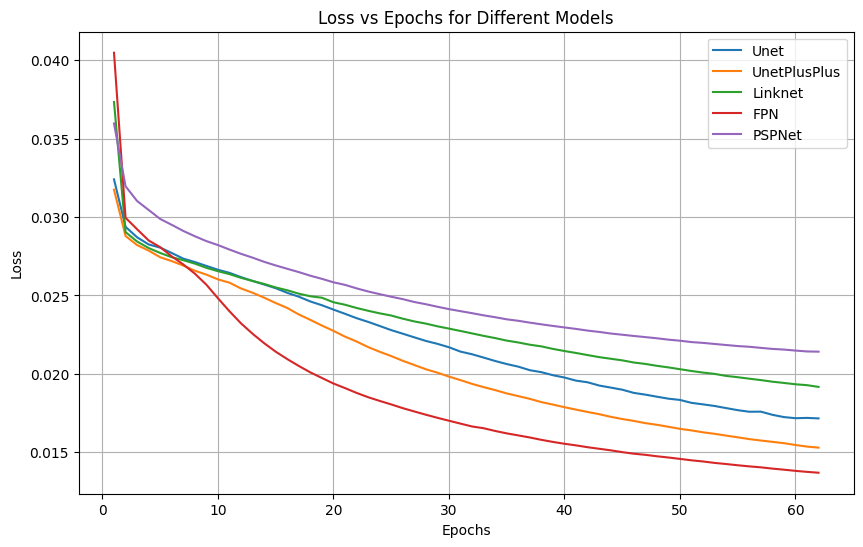

Loss values dictionary stored in 'logs_dice.txt' file.


In [ ]:
model_train_test(orig_test,ground_test,orig_train_dataloader,ground_train_dataloader)